In [1]:
import os.path

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pysensors as ps

from empirical.steinmetz import SteinmetzData, get_mean_firing_rate

In [2]:
mpl.rc('image', cmap='coolwarm')

In [19]:
def plot_comparison(x, y, sensors):
    fig, axes = plt.subplots(3, figsize=(20, 6), sharex='all', sharey='all')
    vmax = np.max(np.concatenate([x, y]))
    axes[0].imshow(y.T, vmin=0, vmax=vmax)
    axes[1].imshow(x.T, vmin=0, vmax=vmax)
    axes[2].imshow((x - y).T, vmin=0, vmax=vmax)
    axes[-1].set_xlabel('Time')
    for ax in axes:
        ax.set_ylabel('Neuron')
    axes[0].set_title('Prediction')
    axes[1].set_title('True state')
    axes[2].set_title('Difference')
    n_sensors = len(sensors)
    axes[0].scatter(np.zeros(n_sensors), sensors,
                    s=2*(1+np.arange(n_sensors)[::-1]), color='k')

In [4]:
def plot_reconstruction_error(models: dict, x, n: int):
    plt.figure(figsize=(4, 3))
    for label, model in models.items():
        errors = model.reconstruction_error(x, np.arange(n))
        plt.plot(errors, label=label)
    plt.xlabel('Num sensors')
    plt.ylabel('Reconstruction error')
    plt.legend()

In [5]:
def get_observation(model, x):
    return x[:, model.get_selected_sensors()]

In [6]:
def test_basis(x_train, x_test, bases: dict, n_sensors: int):
    models = {}
    for label, basis in bases.items():
        model = ps.SSPOR(basis, n_sensors=n_sensors)
        model.fit(x_train)
        models[label] = model
        y = get_observation(model, x_test)
        x_ = model.predict(y)
        plot_comparison(x_test, x_, model.selected_sensors)
        print(f"Reconstruction error with {label} basis and using {n_sensors} "
              f"out of {n_neurons} possible sensors: {-model.score(x_test)}")
    plot_reconstruction_error(models, x_test, n_neurons)

In [7]:
def get_rates(trial_condition):
    areas = ['VISl', 'VISp', 'VISrl']
    area_conditions = {area: data.is_in_area([area]) for area in areas}
    rates = []
    for label, area_condition in area_conditions.items():
        spikes = data.filter_spikes(area_condition, trial_condition)
        r = get_mean_firing_rate(spikes, data.dt, neuron_average=False)
        rates.append(r)
    return np.concatenate(rates).T

In [8]:
path_data = os.path.expanduser('~/Data/steinmetz')
data = SteinmetzData(path_data)

In [9]:
subject_index = 9
data.filter_subject(subject_index);

In [10]:
# Use only trials with stimulus on the right and correct response.
correct_right = np.logical_and(data.response < 0,
                               data.contrast_right > 0)
X_r = get_rates(correct_right)

# Use only trials with stimulus on the left and correct response.
correct_left = np.logical_and(data.response > 0,
                              data.contrast_left > 0)
X_l = get_rates(correct_left)

# Use only trials with no stimulus and correct response.
correct_center = np.logical_and(data.response == 0,
                                np.logical_and(data.contrast_right == 0,
                                               data.contrast_left == 0))
X_c = get_rates(correct_left)

In [14]:
n_sensors = 20
n_basis_modes = 10
n_neurons = 50
t0 = 00  # Time of stimulus presentation

In [15]:
x_train = X_r[:, :n_neurons]
x_test = X_l[:, :n_neurons]

/home/rbodo/PycharmProjects/pysensors/pysensors/basis/_identity.py:71: UserWarning: Only the first 10 examples were retained.
  warn(f"Only the first {self.n_basis_modes} examples were retained.")


Reconstruction error with identity basis and using 20 out of 50 possible sensors: 2.0672165044650685
Reconstruction error with random basis and using 20 out of 50 possible sensors: 1.0783894257363797
Reconstruction error with SVD basis and using 20 out of 50 possible sensors: 0.6760836469278942


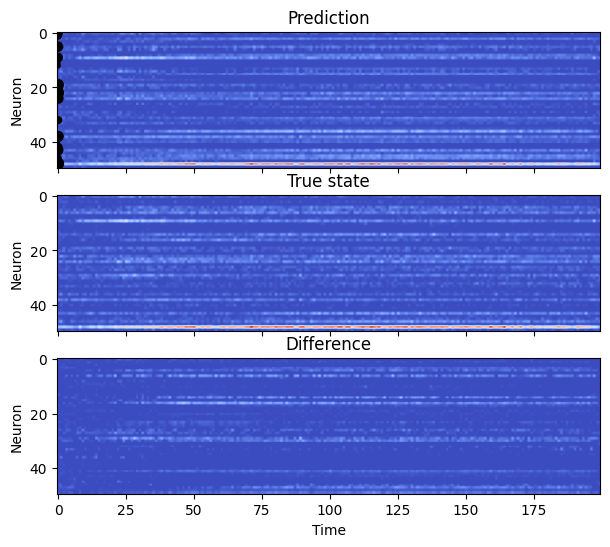

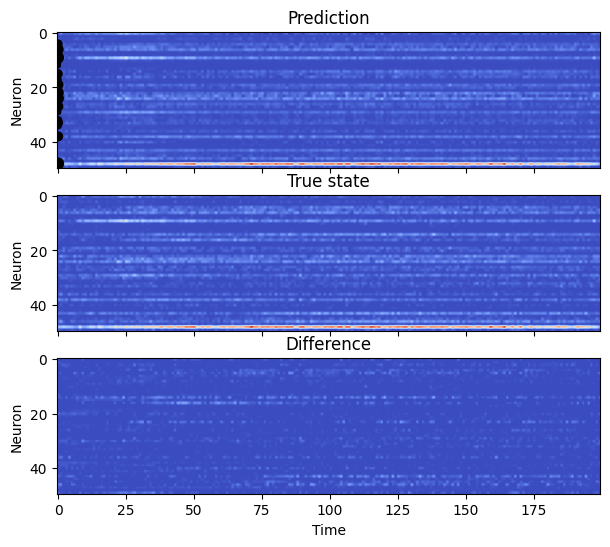

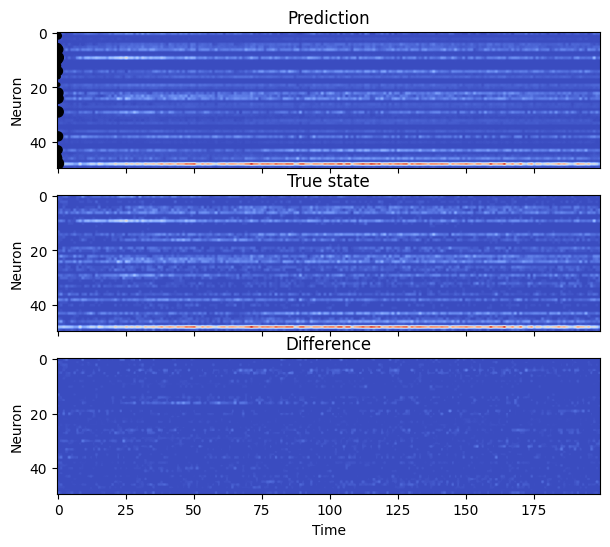

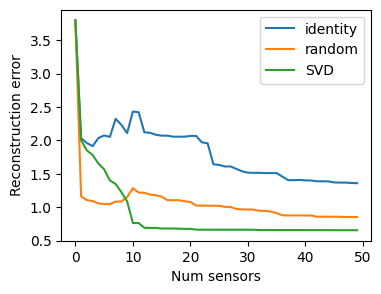

In [20]:
bases = {'identity': ps.basis.Identity(n_basis_modes),
         'random': ps.basis.RandomProjection(n_basis_modes, random_state=42),
         'SVD': ps.basis.SVD(n_basis_modes)}
test_basis(x_train, x_test, bases, n_sensors)